# Data

Let's have a look at the data first

In [1]:
import os
from pathlib import Path

input_data_path = Path(os.environ.get('INPUT_DATA_PATH', '.'))
output_data_path = Path(os.environ.get('OUTPUT_DATA_PATH', '.'))

train_file = str(input_data_path / "data_train.npz")
test_file = str(input_data_path / "data_test.npz")
prediction_file = str(output_data_path / "data_test_prediction.npz")


if not (os.path.isfile(train_file) and
        os.path.isfile(test_file)):
    if not os.path.isfile("input_public_data.zip"):
        !wget https://codalab.coresearch.club/my/datasets/download/37304c34-1d4a-4f43-bcb2-1fdeb37c5cba -O input_public_data.zip
    !unzip -n input_public_data.zip

In [2]:
import numpy as np

In [3]:
data_real = np.load(train_file, allow_pickle=True)

# This is the calorimeter response:
energy = data_real['EnergyDeposit']

# These are the quantities we want to predict
momentum = data_real['ParticleMomentum'][:,:2]
coordinate = data_real['ParticlePoint'][:,:2]

In [4]:
print('energy.shape:', energy.shape)
print('momentum.shape:', momentum.shape)
print('coordinate.shape:', coordinate.shape)

energy.shape: (9916, 30, 30)
momentum.shape: (9916, 2)
coordinate.shape: (9916, 2)


So, we have images of 30x30 pixels and we want to predict 4 numbers for each of them: x, y, px and py.

Let's have a look at some of the images

In [5]:
import matplotlib.pyplot as plt

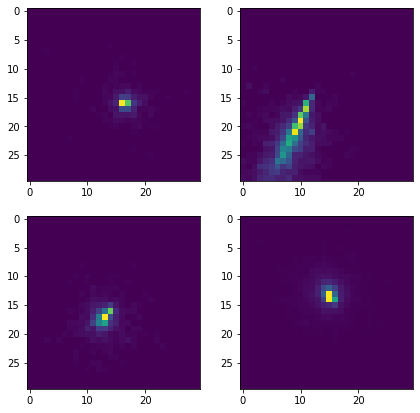

In [6]:
plt.figure(figsize=(7, 7))
plt.subplot(221)
plt.imshow(energy[5])
plt.subplot(222)
plt.imshow(energy[50])
plt.subplot(223)
plt.imshow(energy[500])
plt.subplot(224)
plt.imshow(energy[5000]);

It's also worth knowing how the targets are distributed:

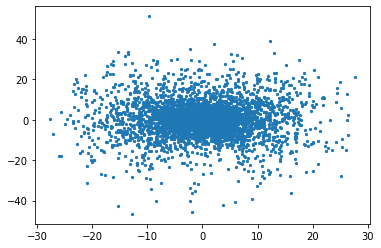

In [7]:
plt.scatter(*momentum.T, s=5);

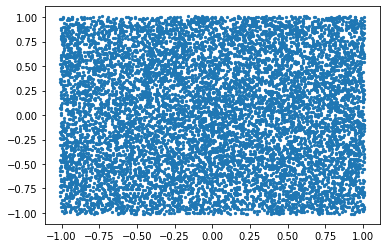

In [8]:
plt.scatter(*coordinate.T, s=5);

Naive approach: can we predict the coordinates from the center of mass position of the calorimeter response?

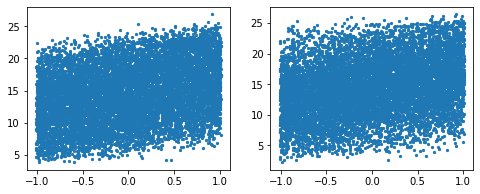

In [9]:
energy_density = energy / energy.sum(axis=(1, 2), keepdims=True)

cell_coords = np.stack([*np.meshgrid(
    np.arange(energy.shape[1]),
    np.arange(energy.shape[2])
)], axis=-1)[None,...]

center_of_mass = (energy_density[...,None] * cell_coords).sum(axis=(1, 2))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(coordinate[:,0], center_of_mass[:,0], s=5)
plt.subplot(122)
plt.scatter(coordinate[:,1], center_of_mass[:,1], s=5);

Looks like the correlation isn't too strong. Maybe higher moments would give us a better picture, but we'll leave such experiments to you.

# Solution

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim

from IPython.display import clear_output
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [11]:
device = torch.device('cuda:2')
# device = torch.device('cpu:0')
device

device(type='cuda', index=2)

### Data Preparation

In [12]:
X = energy[:,None,...] # adding Channels dimension
Y = np.concatenate([coordinate, momentum], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(8924, 1, 30, 30) (8924, 4) (992, 1, 30, 30) (992, 4)


In [13]:
def make_torch_dataset(X, Y, batch_size, shuffle=True):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    ds = utils.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        ds, batch_size=batch_size,
        pin_memory=True, shuffle=shuffle
    )

BATCH_SIZE = 1024

ds_train = make_torch_dataset(X_train, Y_train, BATCH_SIZE)
ds_val = make_torch_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)

In [14]:
def metric_relative_mse(y_true, y_pred):
    return (
        (y_true - y_pred).pow(2).mean(dim=0) / y_true.pow(2).mean(dim=0)
    )

def metric_relative_mse_total(y_true, y_pred):
    return metric_relative_mse(y_true, y_pred).sum()

In [15]:
loss_fn = torch.nn.MSELoss().to(device)

def run_training(regressor, epochs=5, learning_rate = 1e-3):
    opt = optim.Adam(regressor.parameters(), lr=learning_rate)
    losses_train = []
    losses_val = []
    metrics_train = []
    metrics_val = []
    per_component_metrics_train = []
    per_component_metrics_val = []

    for epoch in tqdm(range(epochs)):
        for batch_X, batch_Y in ds_train:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            pred = regressor(batch_X)
                        
            loss = loss_fn(pred, batch_Y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses_train.append(loss.item())
            metrics_train.append(
                metric_relative_mse_total(batch_Y, pred).item()
            )

            per_component_metrics_train.append(
                metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
            )

        avg_loss, avg_metrics, avg_per_component_metrics = [], [], []
        for batch_X, batch_Y in ds_val:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            pred = regressor(batch_X)
            loss = loss_fn(pred, batch_Y)

            avg_loss.append(loss.item())
            avg_metrics.append(
                metric_relative_mse_total(batch_Y, pred).item()
            )
            avg_per_component_metrics.append(
                metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
            )
        losses_val.append(np.mean(avg_loss))
        metrics_val.append(np.mean(avg_metrics))
        per_component_metrics_val.append(
            np.mean(avg_per_component_metrics, axis=0)
        )

        if epoch > 0:
            clear_output()
            plt.figure(figsize=(18, 4.5))

            plt.subplot(131)

            plt.title("Loss")
            plt.plot(losses_train, label='train')
            plt.plot(
                np.linspace(0, len(losses_train), len(losses_val), endpoint=False),
                losses_val, label='val'
            )
            plt.legend()

            plt.subplot(132)

            plt.title("Metric (per component)")
            ms_train = np.array(per_component_metrics_train).T
            ms_val = np.array(per_component_metrics_val).T
            for i, (m_train, m_val, color) in enumerate(zip(ms_train,
                                                            ms_val,
                                                            plt.rcParams['axes.prop_cycle'])):
                plt.plot(m_train, label=f'train (component {i})', c=color['color'])
                plt.plot(
                    np.linspace(0, len(m_train), len(m_val), endpoint=False),
                    m_val, '--', label=f'val (component {i})', c=color['color']
                )
            plt.legend()

            plt.subplot(133)

            plt.title("Metric (total)")
            plt.plot(metrics_train, label='train')
            plt.plot(
                np.linspace(0, len(metrics_train), len(metrics_val), endpoint=False),
                metrics_val, label='val'
            )
            plt.legend()
            plt.show()
        
    # Get final 
    return [metrics_train, per_component_metrics_train], [metrics_val, per_component_metrics_val]

In [16]:
# Disclaimer: this might not be the best architecture for the task

class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=3,
                               kernel_size=7)
        self.pool = nn.MaxPool2d((4, 4))
        self.conv2 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=4)

        self.fc1 = nn.Linear(3 * 3 * 8, 32)
        self.fc2 = nn.Linear(32, 2 + 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(len(x), -1)

        x = F.leaky_relu(self.fc1(x))

        return self.fc2(x)

In [17]:
class ConvBlock(nn.Module):
    def __init__(self,
                 in_channels,     # <== number of input channels to the 1st convolution
                 interm_channels, # <== outputs of the 1st / inputs of the 2nd convolution
                 out_channels,    # <== outputs of the 2nd convolution
                 use_batchnorm,   # <== whether we'll use batchnorm
                 initialization,  # <== function that'll initialize the weights
                 n_paddings, 
                ): 
        # First we run the base class constructor
        super(ConvBlock, self).__init__()

        # And then define all the layers used within a block
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=interm_channels,
                               kernel_size=3, padding=n_paddings)
        self.conv2 = nn.Conv2d(in_channels=interm_channels,
                               out_channels=out_channels,
                               kernel_size=3, padding=n_paddings)
        self.pool = nn.MaxPool2d(2, 2)

        self.use_batchnorm = use_batchnorm
        if use_batchnorm:
            self.bn1 = nn.BatchNorm2d(interm_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)

        # If initialization function provided, call it on the weights of the model
        if initialization is not None:
            initialization(self.conv1.weight)
            initialization(self.conv2.weight)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = F.relu(x)

        x = self.pool(x)
        return x

# The model itself:
class Net(nn.Module):
    def __init__(self, use_batchnorm, initialization):
        super(Net, self).__init__()

        # Convolutional layers:                                         # 3x32x32 (Channels x height x width)
        self.conv1 = ConvBlock(1, 8, 16, use_batchnorm, initialization, n_paddings = 1) # -> 8x32x32 -> 16x32x32 -> 16x16x16
        self.conv2 = ConvBlock(16, 16, 32, use_batchnorm, initialization, n_paddings = 1 ) # -> 16x16x16 -> 32x16x16 -> 32x8x8
        self.conv3 = ConvBlock(32, 32, 64, use_batchnorm, initialization , n_paddings = 1)
        self.conv4 = ConvBlock(64, 128, 256, use_batchnorm, initialization,  n_paddings = 1)
        
        # Fully connected layers:
        #self.fc1 = nn.Linear(1024, 512)
        #self.drop_layer1 = nn.Dropout(p = 0.2)
        self.fc2 = nn.Linear(256, 128)
        #self.drop_layer2 = nn.Dropout(p = 0.1)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 4)


        
        
        # If initialization function provided, call it on the weights of the model
        if initialization is not None:
            #initialization(self.fc1.weight)
            initialization(self.fc2.weight)
            initialization(self.fc3.weight)
            initialization(self.fc4.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = x.reshape(len(x), -1)
        #x = F.relu(self.fc1(x))
        #x = self.drop_layer1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = self.drop_layer2(x)
        x = self.fc4(x)
        return x

In [18]:
# Training parameters
learning_rate = 0.8e-3


# Regularisation configuration 
config = he_normal_init_with_batchnorm=dict(
        use_batchnorm=True,
     initialization=(lambda w: torch.nn.init.kaiming_normal_(w, nonlinearity='relu'))
)


regressor = Net(**config).to(device)
#regressor = Net().to(device)




## Step Learning rate

 - would be better with decay rate ? 

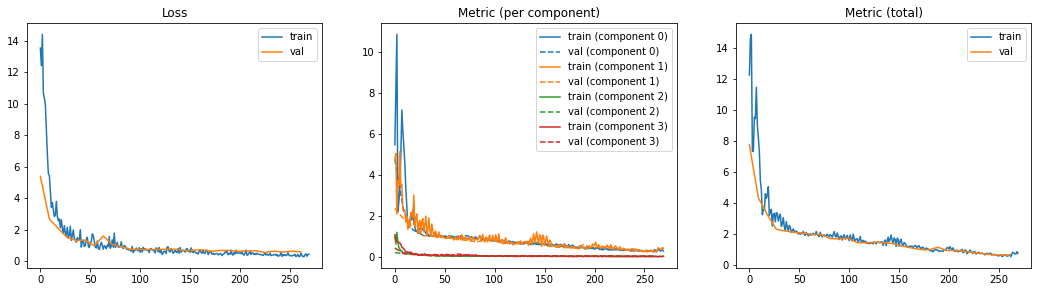

100%|██████████| 30/30 [01:06<00:00,  2.22s/it]

100%|██████████| 30/30 [01:06<00:00,  2.21s/it]

[12.278934478759766, 14.591541290283203, 14.911596298217773, 7.381572723388672, 7.336609840393066, 9.561712265014648, 9.461607933044434, 11.488973617553711, 9.042789459228516, 8.254119873046875, 7.362459659576416, 5.437681198120117, 4.883823394775391, 3.254472017288208, 3.5981831550598145, 3.551506280899048, 4.612297534942627, 4.3080291748046875, 4.5542731285095215, 5.061298370361328, 3.2088305950164795, 3.4838969707489014, 3.6082839965820312, 2.519371747970581, 3.277313709259033, 3.3416988849639893, 2.796643018722534, 3.3827199935913086, 3.357201099395752, 2.842834234237671, 3.1236424446105957, 3.2906737327575684, 2.4952731132507324, 2.6486902236938477, 3.069556713104248, 2.4667367935180664, 2.259817600250244, 2.8119468688964844, 2.4491689205169678, 2.177584409713745, 2.566436767578125, 2.4490365982055664, 2.114629030227661, 2.186023712158203, 2.337830066680908, 2.2012877464294434, 2.1202187538146973, 2.203059673309326, 2.124035596847534, 2.009888172149658, 2.1007606983184814, 1.98285

In [19]:
# Training 
epochs = 30
# Training parameters
learning_rate = 4e-3
train_metric, val_metric = run_training(regressor, epochs = epochs, learning_rate = learning_rate)
print(val_metric[0])



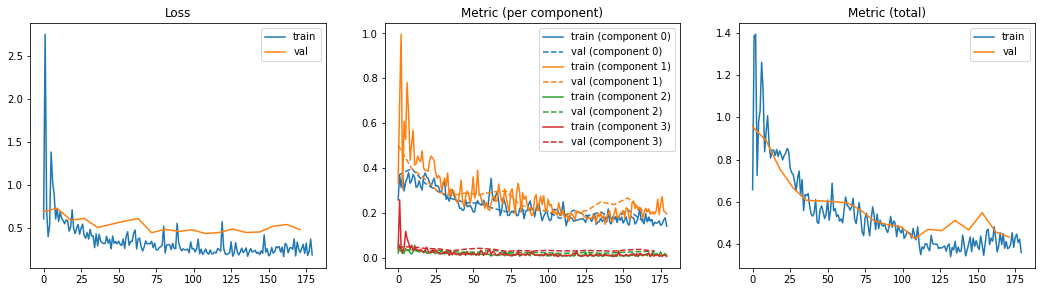

100%|██████████| 20/20 [00:43<00:00,  2.26s/it]

100%|██████████| 20/20 [00:43<00:00,  2.20s/it]

[0.6577382683753967, 1.384210467338562, 1.3926093578338623, 0.7247970700263977, 0.9786316156387329, 1.031484842300415, 1.2603055238723755, 1.124648094177246, 0.8366780877113342, 0.9307581782341003, 1.0073840618133545, 0.8747186064720154, 0.8072444796562195, 0.8460881114006042, 0.8444193601608276, 0.8192320466041565, 0.8474370837211609, 0.8149212002754211, 0.8408082127571106, 0.8239026665687561, 0.7982476949691772, 0.8193222284317017, 0.8289101719856262, 0.8526330590248108, 0.8391224145889282, 0.760947585105896, 0.7380565404891968, 0.7302045822143555, 0.6943915486335754, 0.6530414819717407, 0.711563229560852, 0.7458818554878235, 0.6313808560371399, 0.7055325508117676, 0.5588248372077942, 0.6345226764678955, 0.630023717880249, 0.6393301486968994, 0.5813107490539551, 0.5412886142730713, 0.5326733589172363, 0.5477419495582581, 0.610304057598114, 0.5040695667266846, 0.49804508686065674, 0.5651467442512512, 0.5811748504638672, 0.5535517930984497, 0.5205786228179932, 0.5407257080078125, 0.608

In [20]:
# Training 
epochs = 30
# Training parameters
learning_rate = 2e-3
train_metric, val_metric = run_training(regressor, epochs = epochs, learning_rate = learning_rate)
print(val_metric[0])

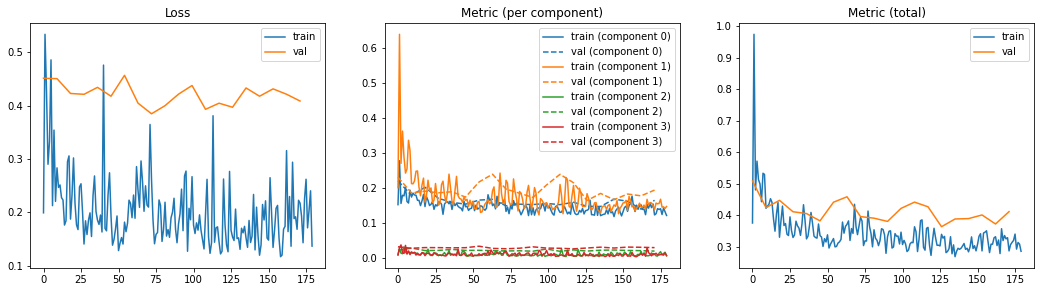

100%|██████████| 20/20 [00:44<00:00,  2.23s/it]

100%|██████████| 20/20 [00:44<00:00,  2.21s/it]

[0.5088803768157959, 0.42449286580085754, 0.44756579399108887, 0.4114188849925995, 0.40571096539497375, 0.38257119059562683, 0.44171637296676636, 0.45894408226013184, 0.3961057960987091, 0.3910200893878937, 0.38076213002204895, 0.42206230759620667, 0.44198909401893616, 0.4271014332771301, 0.3639553189277649, 0.388481467962265, 0.38968536257743835, 0.4012427031993866, 0.37259215116500854, 0.41184061765670776]


In [21]:
# Training 
epochs = 20
# Training parameters
learning_rate = 1.0e-3
train_metric, val_metric = run_training(regressor, epochs = epochs, learning_rate = learning_rate)
print(val_metric[0])

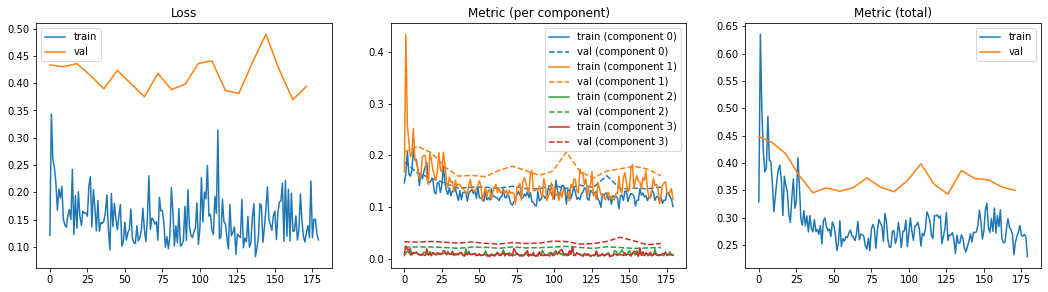

100%|██████████| 20/20 [00:44<00:00,  2.26s/it]

100%|██████████| 20/20 [00:44<00:00,  2.21s/it]

[0.448286771774292, 0.43701404333114624, 0.4162747263908386, 0.37664228677749634, 0.34539997577667236, 0.35424259305000305, 0.3480718731880188, 0.3548491597175598, 0.3726045489311218, 0.3557329773902893, 0.3472142815589905, 0.3676789104938507, 0.3982880413532257, 0.3603810966014862, 0.34294620156288147, 0.3860642910003662, 0.3713062107563019, 0.36903390288352966, 0.3558039367198944, 0.349673867225647]


In [22]:
# Training Step 4
epochs = 20
# Training parameters
learning_rate = 0.8e-3
train_metric, val_metric = run_training(regressor, epochs = epochs, learning_rate = learning_rate)
print(val_metric[0])

### Def scoring - cross-check with scoring given on Coop page 

In [28]:
# Save model
#torch.save(regressor.state_dict(), "./model_best.pt")

# Load model 
regressor = Net(**config).to(device)
dict_model = torch.load("./model_best_33.pt")
regressor.load_state_dict(dict_model)

<All keys matched successfully>

In [29]:
def scoring_function(solution, predict):
    score = 0.
    
    ParticlePoint_sol = solution[:, :2]
    ParticleMomentum_sol = solution[:, 2:]
    
    ParticlePoint_pred = predict[:, :2]
    ParticleMomentum_pred = predict[:, 2:]
    
    score += np.sum(np.square(ParticleMomentum_sol - ParticleMomentum_pred).mean(axis=0) / np.square(ParticleMomentum_sol).mean(axis=0))
    score += np.sum(np.square(ParticlePoint_sol - ParticlePoint_pred).mean(axis=0) / np.square(ParticlePoint_sol).mean(axis=0))
    return score

In [30]:
prediction_val = regressor(torch.tensor(X_val, device=device).float()).cpu()
print(scoring_function(Y_val, prediction_val.detach().numpy()))

0.3277622149760691


### Compress test files

In [31]:
data_test = np.load(test_file, allow_pickle=True)
X_test = data_test['EnergyDeposit'][:,None,...]
prediction_test = regressor(torch.tensor(X_test, device=device).float()).cpu()
coordinate_test, momentum_test = (
    prediction_test.detach().numpy()[:, :2],
    prediction_test.detach().numpy()[:, 2:],
)

np.savez_compressed(prediction_file,
                    ParticlePoint=coordinate_test,
                    ParticleMomentum=momentum_test)